# Robyn Budget Allocator Demo

This notebook demonstrates how to use the Python implementation of Robyn's budget allocator.
It shows how to:
1. Load and prepare data
2. Configure the allocator
3. Run optimization scenarios
4. Analyze and visualize results

## Step 1: Load Exported R Data

In [1]:
## Step 1: Setup and Import
import sys
import os
import pandas as pd
import numpy as np
from typing import Dict, Any, Union, List
import matplotlib.pyplot as plt

# Import necessary Robyn classes
from robyn.data.entities.mmmdata import MMMData
from robyn.modeling.entities.modeloutputs import ModelOutputs
from robyn.data.entities.hyperparameters import Hyperparameters
from robyn.allocator.entities.enums import OptimizationScenario, ConstrMode
from robyn.allocator.budget_allocator import BudgetAllocator
from robyn.modeling.pareto.pareto_optimizer import ParetoResult
from robyn.allocator.entities.allocation_config import AllocationConfig
from robyn.allocator.entities.allocation_constraints import AllocationConstraints
from robyn.visualization.allocator_visualizer import AllocationPlotter
from utils.data_mapper import load_data_from_json, import_input_collect, import_output_collect, import_output_models

/Users/yijuilee/robynpy_release_reviews/robynvenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data from JSON exported from R
raw_input_collect = load_data_from_json(
    "/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/tutorials/data/Allocator_InputCollect.json"
)
raw_output_collect = load_data_from_json(
    "/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/tutorials/data/Allocator_OutputCollect.json"
)
raw_output_models = load_data_from_json(
    "/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/tutorials/data/Allocator_OutputModels.json"
)

# Convert R data to Python objects
r_input_collect = import_input_collect(raw_input_collect)
r_output_collect = import_output_collect(raw_output_collect)
python_model_outputs = import_output_models(raw_output_models)

# Extract individual components
mmm_data = r_input_collect["mmm_data"]
featurized_mmm_data = r_input_collect["featurized_mmm_data"]
holidays_data = r_input_collect["holidays_data"]
model_outputs = python_model_outputs
hyperparameters = r_input_collect["hyperparameters"]

# Print data summary
print(f"Data loaded successfully:")
print(
    f"- Data timeframe: {mmm_data.data[mmm_data.mmmdata_spec.date_var].min()} to {mmm_data.data[mmm_data.mmmdata_spec.date_var].max()}"
)
print(f"- Number of paid media channels: {len(mmm_data.mmmdata_spec.paid_media_spends)}")
print(f"- Channels: {mmm_data.mmmdata_spec.paid_media_spends}")

Data loaded successfully:
- Data timeframe: DATE    2015-11-23
dtype: object to DATE    2019-11-11
dtype: object
- Number of paid media channels: 5
- Channels: ['tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S']


## Step 2: Set up Budget Allocator

Initialize the budget allocator with the selected model and data.

In [3]:
for solid in r_output_collect["pareto_result"].result_hyp_param["solID"]:
    print(f"Solution ID: {solid}")

Solution ID: 1_65_6
Solution ID: 1_150_3
Solution ID: 1_156_9
Solution ID: 1_160_3
Solution ID: 1_166_9
Solution ID: 1_208_4
Solution ID: 1_217_2
Solution ID: 2_85_3
Solution ID: 2_87_4
Solution ID: 2_93_9
Solution ID: 2_95_3
Solution ID: 2_97_3
Solution ID: 2_100_6
Solution ID: 2_101_9
Solution ID: 2_144_8
Solution ID: 2_170_8
Solution ID: 2_178_6
Solution ID: 2_197_8
Solution ID: 2_198_3
Solution ID: 2_198_9
Solution ID: 2_201_6
Solution ID: 2_204_9
Solution ID: 2_207_8
Solution ID: 2_208_2
Solution ID: 2_208_9
Solution ID: 2_214_8
Solution ID: 2_215_9
Solution ID: 2_217_6
Solution ID: 2_218_2
Solution ID: 2_218_3
Solution ID: 2_218_4
Solution ID: 2_220_1
Solution ID: 2_221_2
Solution ID: 2_221_5
Solution ID: 2_221_6
Solution ID: 3_66_5
Solution ID: 3_71_1
Solution ID: 3_74_4
Solution ID: 3_75_4
Solution ID: 3_77_7
Solution ID: 3_78_7
Solution ID: 3_78_9
Solution ID: 3_81_1
Solution ID: 3_82_3
Solution ID: 3_85_4
Solution ID: 3_91_1
Solution ID: 3_91_7
Solution ID: 3_95_4
Solution ID

In [4]:
# Select model ID from available solutions
select_model = "3_186_4"  # This should match one of your model IDs


# Initialize budget allocator
allocator = BudgetAllocator(
    mmm_data=mmm_data,
    featurized_mmm_data=featurized_mmm_data,
    model_outputs=model_outputs,
    pareto_result=r_output_collect["pareto_result"],  # Get ParetoResult from import_output_collect()
    select_model=select_model,
)

## Step 3: Configure Allocation Settings

Set up constraints and parameters for optimization.

In [5]:
# Create channel constraints
channel_constraints = AllocationConstraints(
    channel_constr_low={channel: 0.7 for channel in mmm_data.mmmdata_spec.paid_media_spends},
    channel_constr_up={channel: 1.2 for channel in mmm_data.mmmdata_spec.paid_media_spends},
    channel_constr_multiplier=3.0,
)

## Step 4: Run Different Optimization Scenarios

### Scenario 1: Default Max Response

In [6]:
# Create base constraints matching R example
channel_constraints = AllocationConstraints(
    channel_constr_low={
        "tv_S": 0.7,  # -30% from base
        "ooh_S": 0.7,
        "print_S": 0.7,
        "facebook_S": 0.7,
        "search_S": 0.7,
    },
    channel_constr_up={
        "tv_S": 1.2,  # +20% from base
        "ooh_S": 1.5,  # +50% from base
        "print_S": 1.5,
        "facebook_S": 1.5,
        "search_S": 1.5,
    },
    channel_constr_multiplier=3.0,
)

# Configure max response scenario
max_response_config = AllocationConfig(
    scenario=OptimizationScenario.MAX_RESPONSE,
    constraints=channel_constraints,
    date_range="last",  # Use last period as initial
    total_budget=None,  # Use historical budget
    maxeval=100000,
    optim_algo="SLSQP_AUGLAG",
    constr_mode=ConstrMode.EQUALITY,
    plots=True,
)

# Run optimization
result = allocator.allocate(max_response_config)

# Print results
print(
    f"""
Model ID: {select_model}
Scenario: {max_response_config.scenario}
Use case: {result.metrics.get('use_case', '')}
Window: {result.metrics.get('date_range_start')}:{result.metrics.get('date_range_end')} ({result.metrics.get('n_periods')} {mmm_data.mmmdata_spec.interval_type})

Dep. Variable Type: {mmm_data.mmmdata_spec.dep_var_type}
Media Skipped: {result.metrics.get('skipped_channels', 'None')}
Relative Spend Increase: {result.metrics.get('spend_lift_pct', 0):.1f}% ({result.metrics.get('spend_lift_abs', 0):+.0f}K)
Total Response Increase (Optimized): {result.metrics.get('response_lift', 0)*100:.1f}%

Allocation Summary:
"""
)

# Print channel-level results
for channel in mmm_data.mmmdata_spec.paid_media_spends:
    current = result.optimal_allocations[result.optimal_allocations["channel"] == channel].iloc[0]

    print(
        f"""
- {channel}:
  Optimizable bound: [{(current['constr_low']-1)*100:.0f}%, {(current['constr_up']-1)*100:.0f}%],
  Initial spend share: {current['current_spend_share']*100:.2f}% -> Optimized bounded: {current['optimal_spend_share']*100:.2f}%
  Initial response share: {current['current_response_share']*100:.2f}% -> Optimized bounded: {current['optimal_response_share']*100:.2f}%
  Initial abs. mean spend: {current['current_spend']/1000:.3f}K -> Optimized: {current['optimal_spend']/1000:.3f}K [Delta = {(current['optimal_spend']/current['current_spend']-1)*100:.0f}%]
"""
    )


Model ID: 3_186_4
Scenario: max_response
Use case: 
Window: 2019-11-11 00:00:00:2019-11-11 00:00:00 (1 week)

Dep. Variable Type: revenue
Media Skipped: None
Relative Spend Increase: 0.0% (+0K)
Total Response Increase (Optimized): 4.2%

Allocation Summary:


- tv_S:
  Optimizable bound: [-30%, 20%],
  Initial spend share: 7.14% -> Optimized bounded: 5.00%
  Initial response share: 2.39% -> Optimized bounded: 1.64%
  Initial abs. mean spend: 1.221K -> Optimized: 0.854K [Delta = -30%]


- ooh_S:
  Optimizable bound: [-30%, 50%],
  Initial spend share: 7.14% -> Optimized bounded: 5.00%
  Initial response share: 2.58% -> Optimized bounded: 1.98%
  Initial abs. mean spend: 1.221K -> Optimized: 0.854K [Delta = -30%]


- print_S:
  Optimizable bound: [-30%, 50%],
  Initial spend share: 7.14% -> Optimized bounded: 5.00%
  Initial response share: 0.02% -> Optimized bounded: 0.01%
  Initial abs. mean spend: 1.221K -> Optimized: 0.854K [Delta = -30%]


- facebook_S:
  Optimizable bound: [-30%, 5

/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/robyn/allocator/budget_allocator.py:497: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_spend = max(optimal_spend_np[i], current_spend_np[i]) * 1.5
/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/robyn/allocator/budget_allocator.py:530: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "is_current": np.isclose(spend_range[j], current_spend_np[i], rtol=1e-3),


### Scenario 2: Max Response with Custom Settings

In [7]:
# ### Scenario 2: Max Response with Custom Settings
# print("\nScenario 2: Maximize response for last 10 periods with custom budget")
# custom_low_constraints = {
#     channel: (0.8 if i == 0 else 0.7) for i, channel in enumerate(mmm_data.mmmdata_spec.paid_media_spends)
# }
# custom_up_constraints = {
#     channel: (1.2 if i == 0 else 1.5) for i, channel in enumerate(mmm_data.mmmdata_spec.paid_media_spends)
# }

# allocator_constraints2 = AllocationConstraints(
#     channel_constr_low=custom_low_constraints, channel_constr_up=custom_up_constraints, channel_constr_multiplier=5.0
# )

# max_response_config2 = AllocationConfig(
#     scenario=OptimizationScenario.MAX_RESPONSE,
#     constraints=allocator_constraints2,
#     date_range="last_10",
#     total_budget=5000000,
#     maxeval=100000,
#     plots=True,
# )
# result2 = allocator.allocate(max_response_config2)

### Scenario 3: Target Efficiency
Optimize allocation based on target ROI/CPA.

In [8]:
### Scenario 3: Default Target Efficiency (Target ROAS or CPA)
print("\nScenario 3: Target efficiency optimization")

# Create constraints matching R's implementation
default_channel_constraints = AllocationConstraints(
    channel_constr_low={
        channel: 0.1 for channel in mmm_data.mmmdata_spec.paid_media_spends  # -90% from base for all channels
    },
    channel_constr_up={
        channel: 10.0 for channel in mmm_data.mmmdata_spec.paid_media_spends  # +900% from base for all channels
    },
    channel_constr_multiplier=1.0,  # Don't extend bounds for target efficiency
    is_target_efficiency=True,  # Flag this as target efficiency scenario
)

# Create configuration for target efficiency scenario
target_efficiency_config = AllocationConfig(
    scenario=OptimizationScenario.TARGET_EFFICIENCY,
    constraints=default_channel_constraints,
    date_range="all",  # Use all dates like in R version
    target_value=None,  # Will use default 80% of initial ROAS or 120% of initial CPA
    maxeval=100000,
    optim_algo="SLSQP_AUGLAG",
    constr_mode=ConstrMode.EQUALITY,
    plots=True,
)

# Run optimization
result3 = allocator.allocate(target_efficiency_config)

# Print results matching R format
print(
    f"""
Model ID: {select_model}
Scenario: {target_efficiency_config.scenario}
Use case: {result3.metrics.get('use_case', '')}
Window: {result3.metrics.get('date_range_start')}:{result3.metrics.get('date_range_end')} ({result3.metrics.get('n_periods')} {mmm_data.mmmdata_spec.interval_type})

Dep. Variable Type: {mmm_data.mmmdata_spec.dep_var_type}
Media Skipped: {result3.metrics.get('skipped_channels', 'None')}
Relative Spend Increase: {result3.metrics.get('spend_lift_pct', 0):.0f}% ({result3.metrics.get('spend_lift_abs', 0):.0f})
Total Response Increase (Optimized): {result3.metrics.get('response_lift', 0)*100:.0f}%

Allocation Summary:
"""
)

# Print channel-level results
for channel in mmm_data.mmmdata_spec.paid_media_spends:
    current = result3.optimal_allocations[result3.optimal_allocations["channel"] == channel].iloc[0]

    print(
        f"""
- {channel}:
  Optimizable bound: [{(current['constr_low']-1)*100:.0f}%, {(current['constr_up']-1)*100:.0f}%],
  Initial spend share: {current['current_spend_share']*100:.2f}% -> Optimized bounded: {current['optimal_spend_share']*100:.2f}%
  Initial response share: {current['current_response_share']*100:.2f}% -> Optimized bounded: {current['optimal_response_share']*100:.2f}%
  Initial abs. mean spend: {current['current_spend']/1000:.3f}K -> Optimized: {current['optimal_spend']/1000:.3f}K [Delta = {(current['optimal_spend']/current['current_spend']-1)*100:.0f}%]
"""
    )


Scenario 3: Target efficiency optimization

Model ID: 3_186_4
Scenario: target_efficiency
Use case: all_historical_vec + historical_budget
Window: 2015-11-23 00:00:00:2019-11-11 00:00:00 (208 week)

Dep. Variable Type: revenue
Media Skipped: None
Relative Spend Increase: 657% (459)
Total Response Increase (Optimized): 506%

Allocation Summary:


- tv_S:
  Optimizable bound: [-90%, 900%],
  Initial spend share: 21.25% -> Optimized bounded: 28.07%
  Initial response share: 30.15% -> Optimized bounded: 22.76%
  Initial abs. mean spend: 14.844K -> Optimized: 148.437K [Delta = 900%]


- ooh_S:
  Optimizable bound: [-90%, 900%],
  Initial spend share: 61.87% -> Optimized bounded: 49.64%
  Initial response share: 26.04% -> Optimized bounded: 8.66%
  Initial abs. mean spend: 43.218K -> Optimized: 262.553K [Delta = 508%]


- print_S:
  Optimizable bound: [-90%, 900%],
  Initial spend share: 5.34% -> Optimized bounded: 7.05%
  Initial response share: 0.61% -> Optimized bounded: 9.51%
  Initial 

### Scenario 4: Custom Target Efficiency

In [9]:
# print("\nScenario 4: Target efficiency with custom target value")
# target_efficiency_config2 = AllocationConfig(
#     scenario=OptimizationScenario.TARGET_EFFICIENCY,
#     constraints=channel_constraints,
#     date_range="last",
#     target_value=2.0,
#     maxeval=100000,
#     plots=True,
# )
# result4 = allocator.allocate(target_efficiency_config2)

## Step 5: Visualize Results (One Pager)

Plot the optimization results and response curves.

Max Response Scenario Plots:
--------------------------------------------------

spend_allocation:

response_curves:

efficiency_frontier:

spend_vs_response:

summary_metrics:

Target Efficiency Scenario Plots:
--------------------------------------------------

spend_allocation:

response_curves:

efficiency_frontier:

spend_vs_response:

summary_metrics:


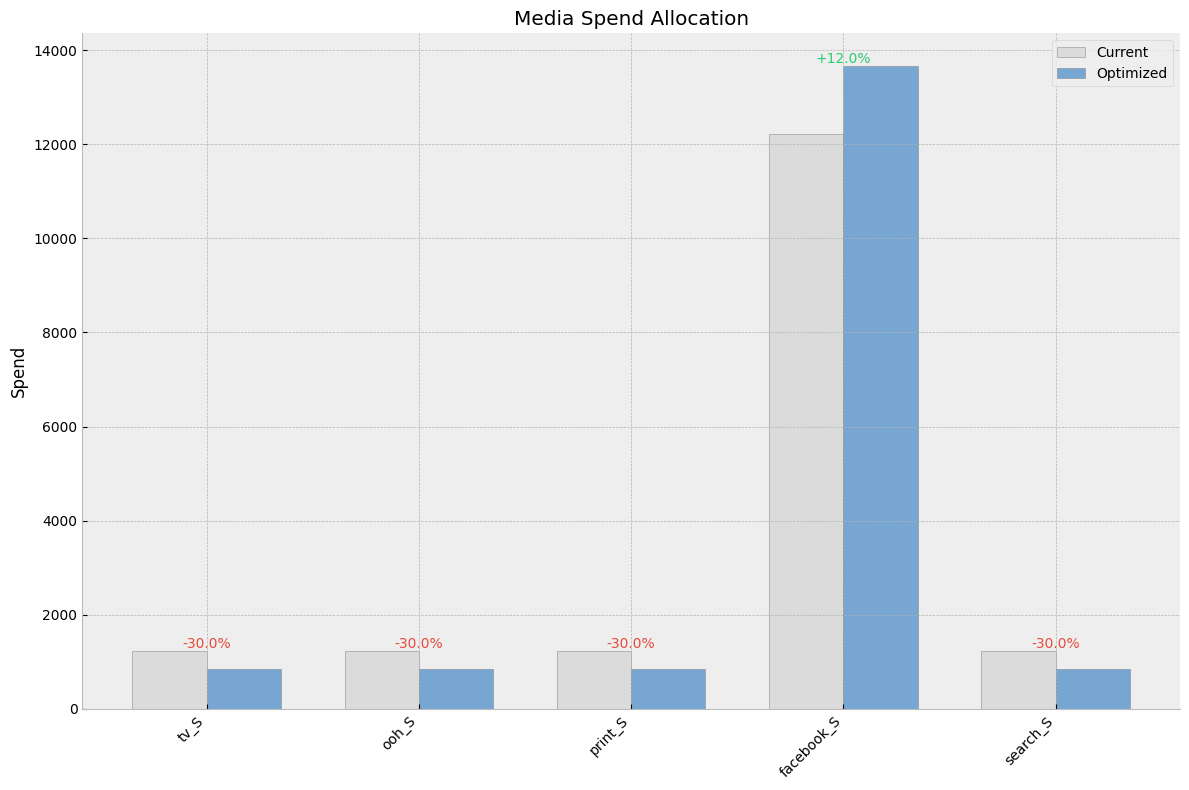

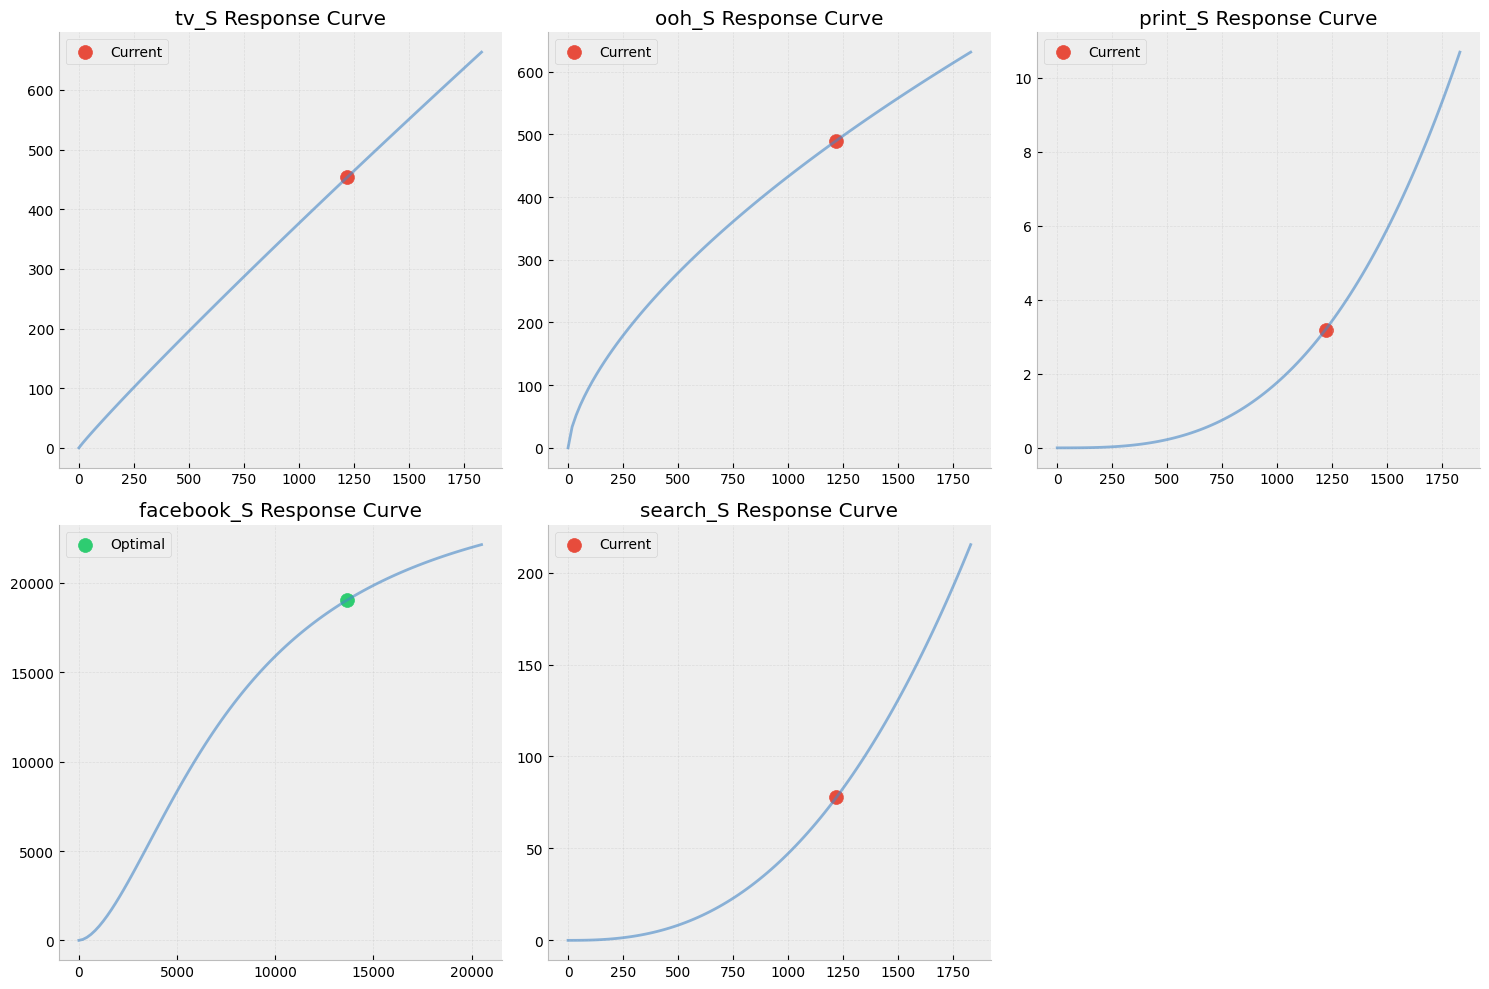

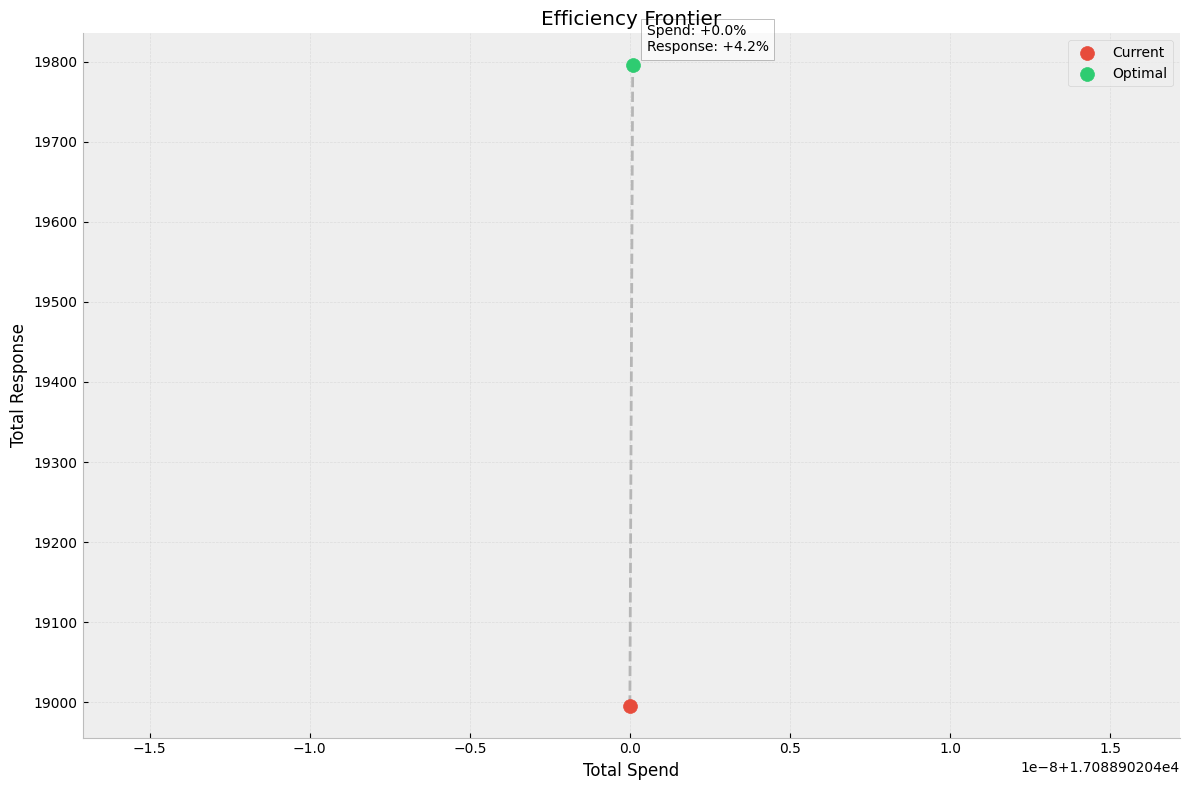

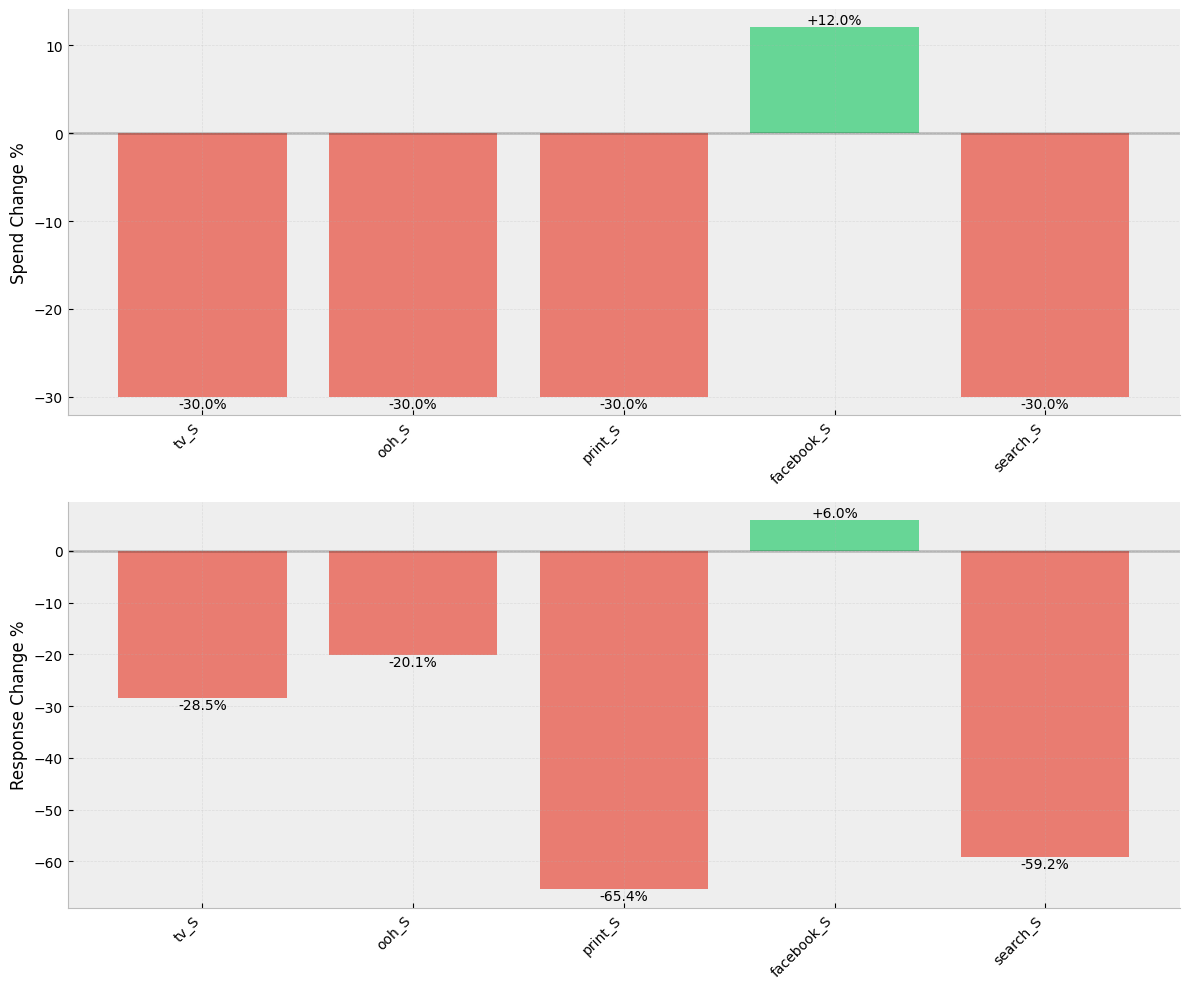

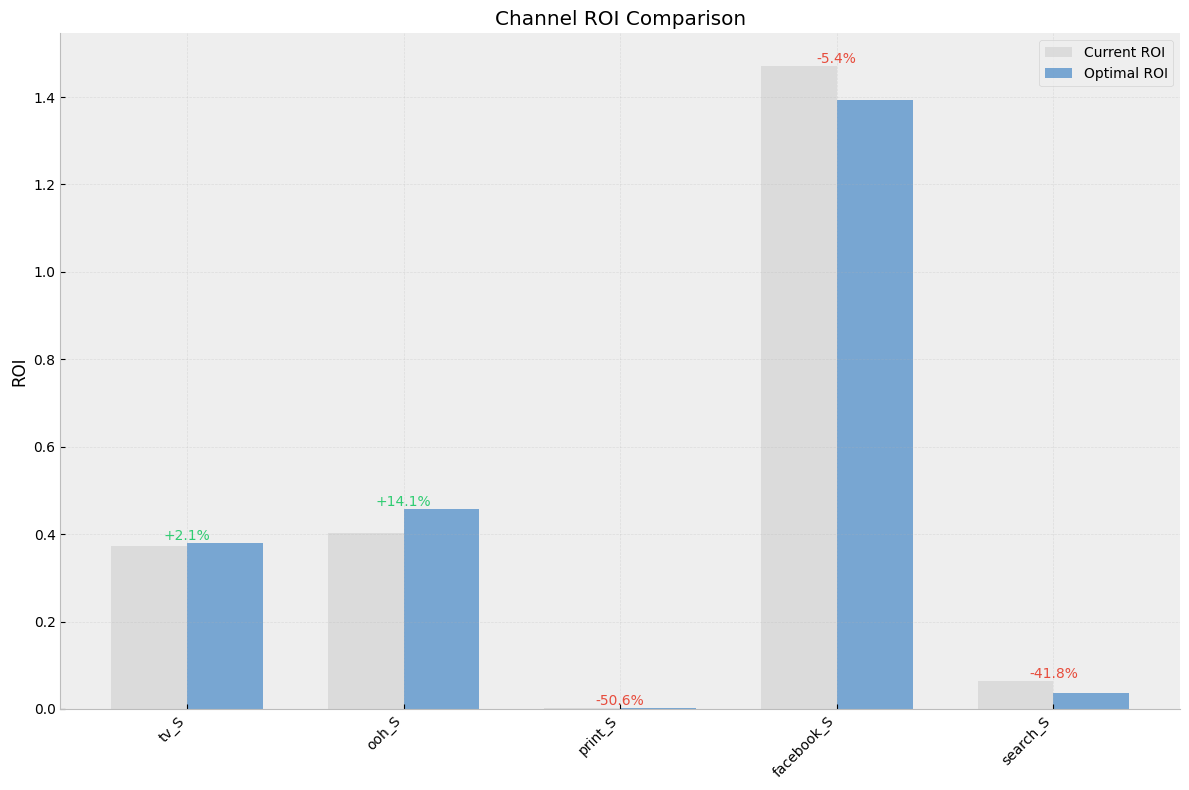

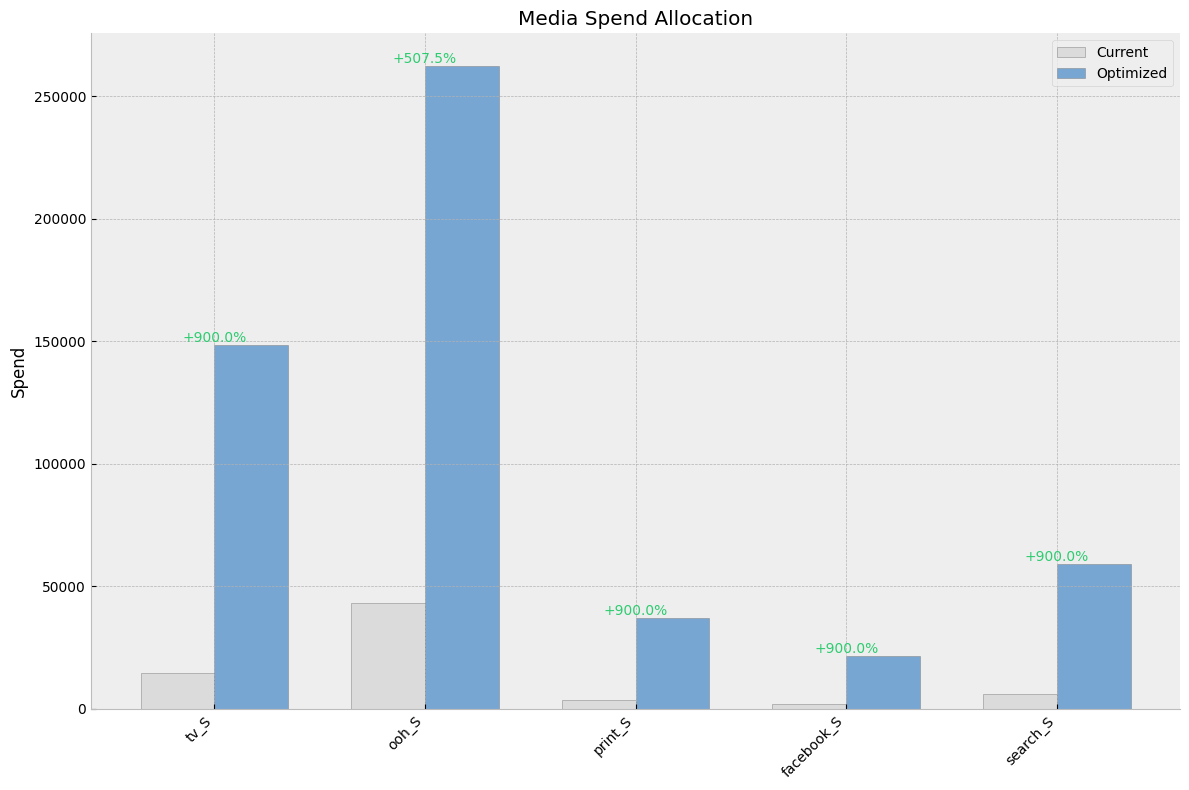

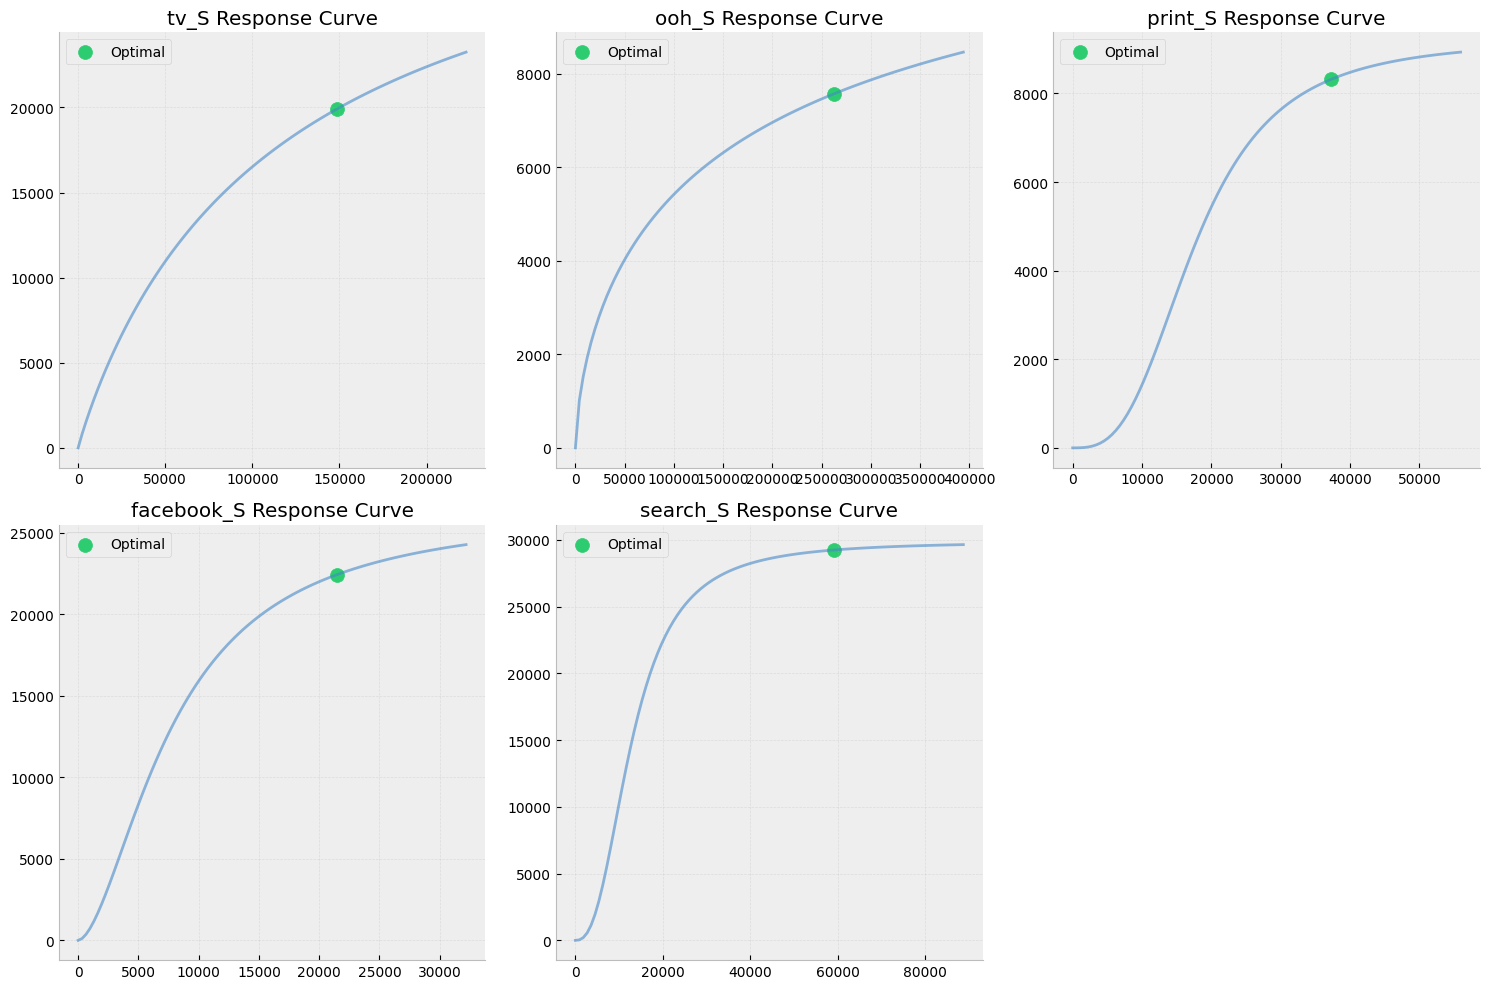

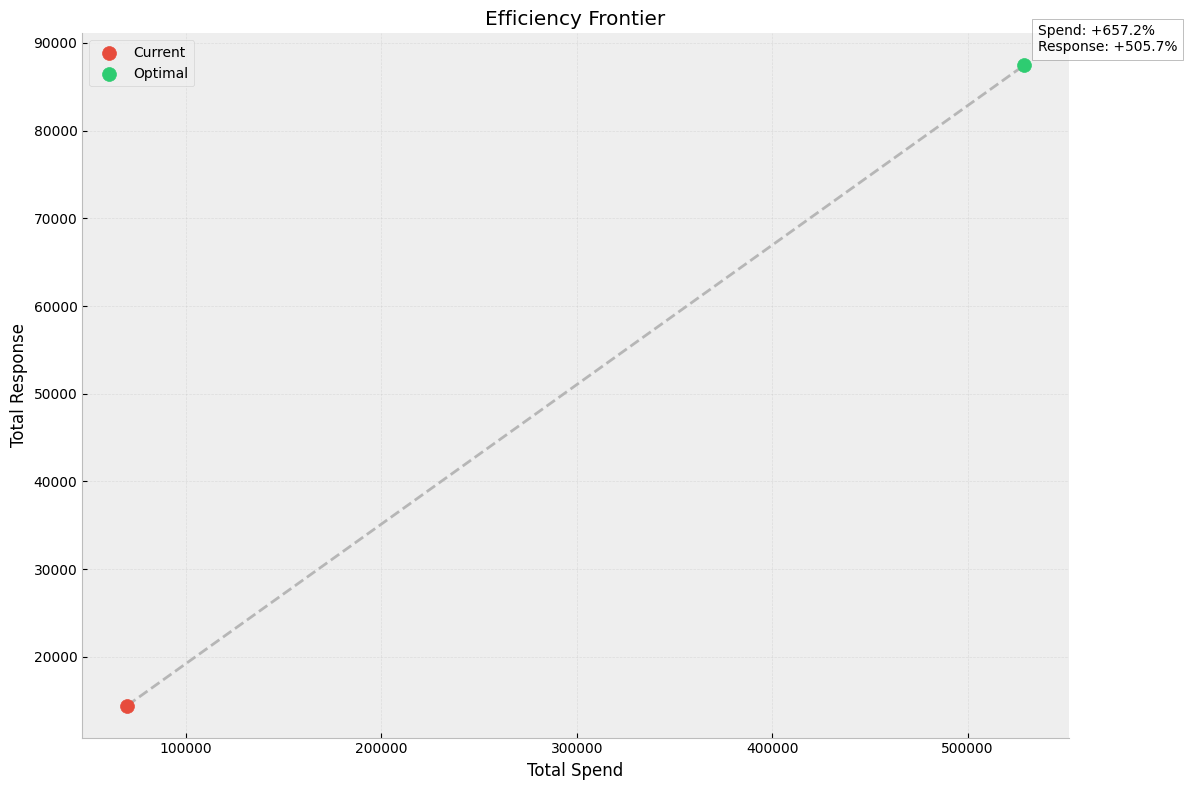

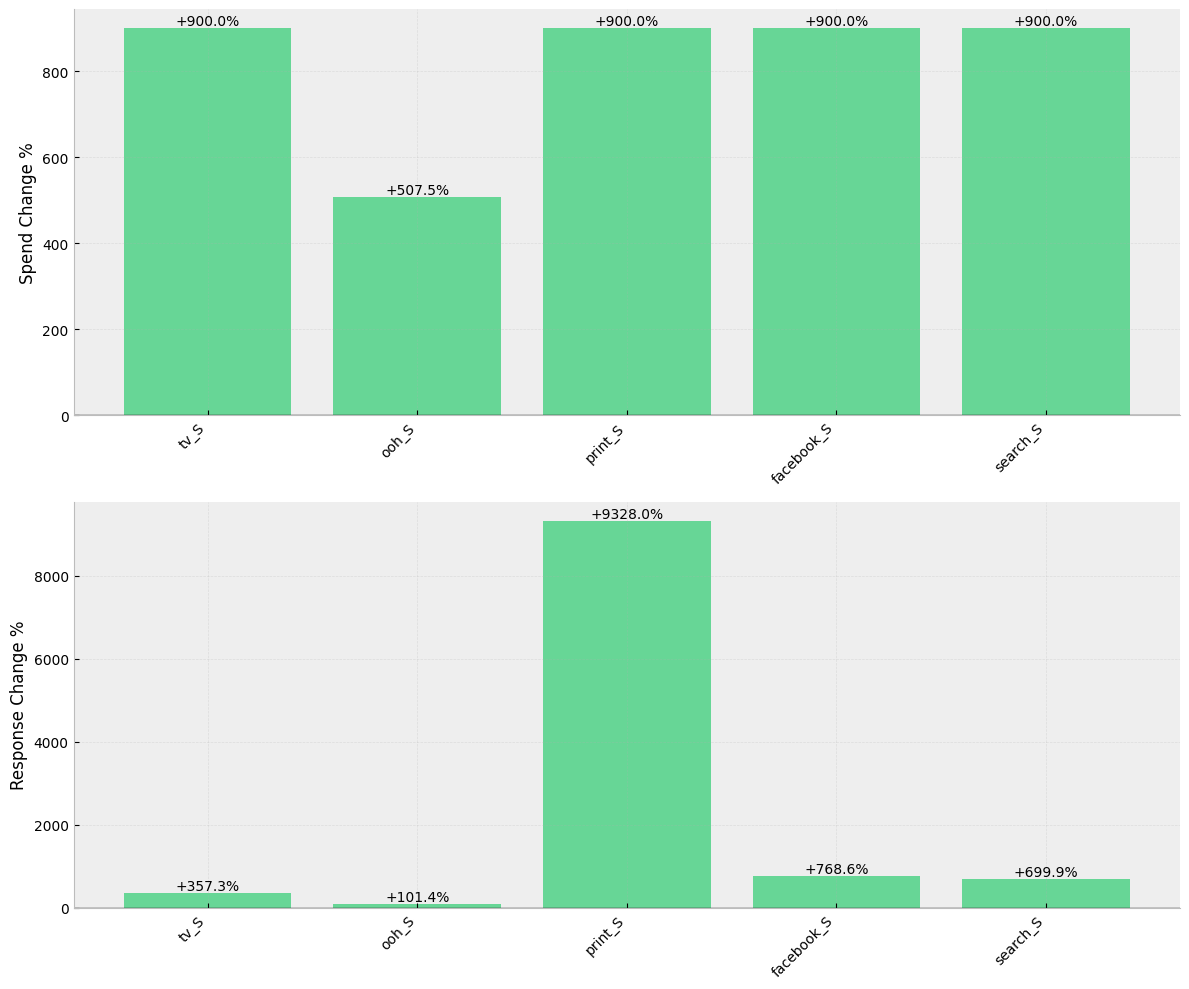

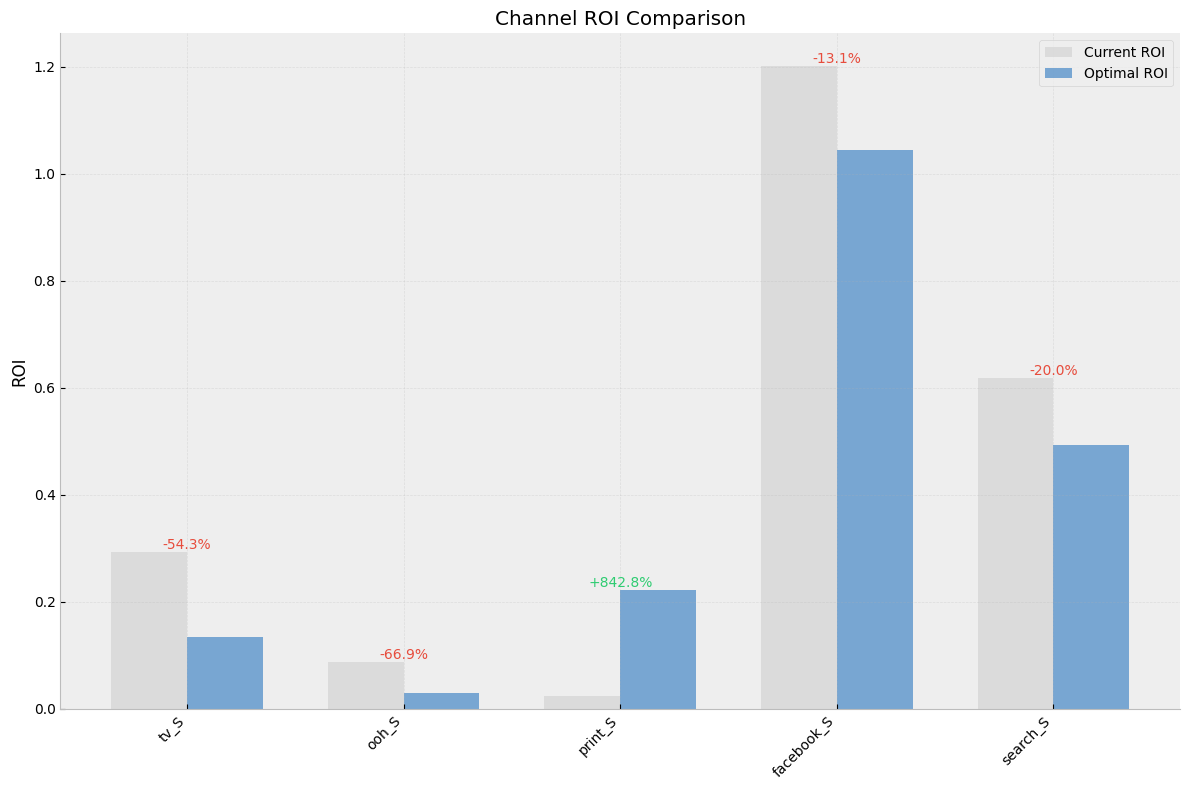

In [10]:
# Create visualizations for each scenario
max_response_plotter = AllocationPlotter(result)
target_efficiency_plotter = AllocationPlotter(result3)

# Generate plots
max_response_plots = max_response_plotter.plot_all()
target_efficiency_plots = target_efficiency_plotter.plot_all()

# Display plots
print("Max Response Scenario Plots:")
print("-" * 50)
for plot_name, fig in max_response_plots.items():
    print(f"\n{plot_name}:")
    plt.figure(fig.number)


print("\nTarget Efficiency Scenario Plots:")
print("-" * 50)
for plot_name, fig in target_efficiency_plots.items():
    print(f"\n{plot_name}:")
    plt.figure(fig.number)